In [83]:
import sys
import numpy as np
import pandas as pd
import igraph as ig
import json
import csv
import matplotlib.pyplot as plt 
from scipy.spatial import Delaunay
from tqdm import tqdm 
from collections import defaultdict
from copy import deepcopy

### Question 9

In [84]:
df = pd.read_csv('los_angeles-censustracts-2019-4-All-MonthlyAggregate.csv', usecols=['sourceid', 'dstid', 'mean_travel_time', 'month'])
df = df[df['month']==12][['sourceid', 'dstid', 'mean_travel_time']]
# change start of movement id 1 -> 0
edges = df.sub([1, 1, 0])
edges.rename(columns = {'mean_travel_time':'time'}, inplace = True)

In [85]:
vertices_dict = defaultdict(list)
with open('los_angeles_censustracts.json') as f:
    census_tracts = json.loads(f.readline())
    for area in census_tracts['features']:
        # change start of movement id 1 -> 0
        id = int(area['properties']['MOVEMENT_ID']) - 1
        display = area['properties']['DISPLAY_NAME']
        a = area['geometry']['coordinates'][0]
        # considering polygon & multipolygon area types
        centloc = np.array(a if type(a[0][0]) == float else a[0]).mean(axis=0)
        vertices_dict['id'].append(id)
        vertices_dict['display'].append(display)
        vertices_dict['centloc'].append(centloc)

vertices = pd.DataFrame(vertices_dict)

In [86]:
g = ig.Graph.DataFrame(edges, directed=False, vertices=vertices)
gcc = g.clusters().giant()
gcc = gcc.simplify(combine_edges=dict(time='mean'))
gcc.es['distance'] = [np.linalg.norm(gcc.vs[e.source]["centloc"] - gcc.vs[e.target]["centloc"]) * 69
                      for e in gcc.es]
gcc.es['mark'] = [False] * len(gcc.es)
print(len(gcc.vs), len(gcc.es))

2649 1003858


### Question 10

In [113]:
mst = gcc.spanning_tree(weights=gcc.es['time'])
for i, e in enumerate(mst.es):
    print('Distance in miles: {:.3f}\nTime taken: {:.1f}\n'
        .format(e['distance'], e['time']))
    if i > 3: break
    
visual_style = {}
visual_style["vertex_size"] = 3
out = ig.plot(mst,**visual_style)
out.save('images/' + 'Q10' + '.png')

Distance in miles: 0.885
Time taken: 129.8

Distance in miles: 0.570
Time taken: 118.3

Distance in miles: 0.447
Time taken: 90.2

Distance in miles: 0.621
Time taken: 126.5

Distance in miles: 0.812
Time taken: 125.7



### Question 11

In [88]:
# traingle inequality
N = 1000
counter = 0
i = 0
while i < N:
    points = np.random.randint(1, high=len(gcc.vs), size=3)
    try:
        e1, e2, e3 = gcc.get_eid(points[0], points[1]), gcc.get_eid(points[1], points[2]), gcc.get_eid(points[2], points[0])
        w1, w2, w3 = gcc.es['time'][e1], gcc.es['time'][e2], gcc.es['time'][e3]       
    except: continue
    i += 1
    if w1+w2>w3 and w1+w3>w2 and w3+w2>w1: 
        counter += 1
print(counter / N)

0.915


### Question 12

In [89]:
def preorderTraversal(g, root): 
    stack = []
    preorder =[] 
    preorder.append(root) 
    stack.append(root) 
    while len(stack)>0:
        flag = 0
        if g.vs[stack[-1]].degree(mode='OUT') == 0: 
            stack.pop() 
        else: 
            par = stack[-1]
        for child in g.vs[par].neighbors(mode='OUT'): 
            if child.index not in preorder: 
                flag = 1
                stack.append(child.index) 
                preorder.append(child.index) 
                break
        if flag == 0: 
            stack.pop() 
    return preorder

In [90]:
def twoApprox(root): 
    pre = preorderTraversal(mst, root)
    pre.append(root)
    cost_approx = 0
    final_path = [root]
    for i in range(len(pre) - 1):
        eid = gcc.get_eid(pre[i], pre[i+1], directed=False, error=False)
        if eid != -1:
            cost_approx += gcc.es[eid]['time']
            final_path.append(pre[i+1])
        else:
            cost_approx += (gcc.shortest_paths(pre[i], pre[i+1], weights='time'))[0][0]
            path = gcc.get_shortest_paths(pre[i], pre[i+1], weights='time', output='vpath')
            for ind in path[0][1:]:
                final_path.append(ind)
    return cost_approx, final_path

In [91]:
cost_mst = sum(mst.es['time'])
cost_approx_min = sys.maxsize
path_approx = []
points = np.random.randint(1, high=len(gcc.vs), size=30)
for point in tqdm(points):
    cost, path = twoApprox(point)
    if cost < cost_approx_min:
        cost_approx_min = cost
        path_approx = path

upper = cost_approx_min / cost_mst
print(cost_mst)
print(cost_approx_min)
print(upper)

100%|██████████| 30/30 [01:26<00:00,  2.88s/it]

269084.5449999994
455291.6399999996
1.6920021920991435


### Question 13

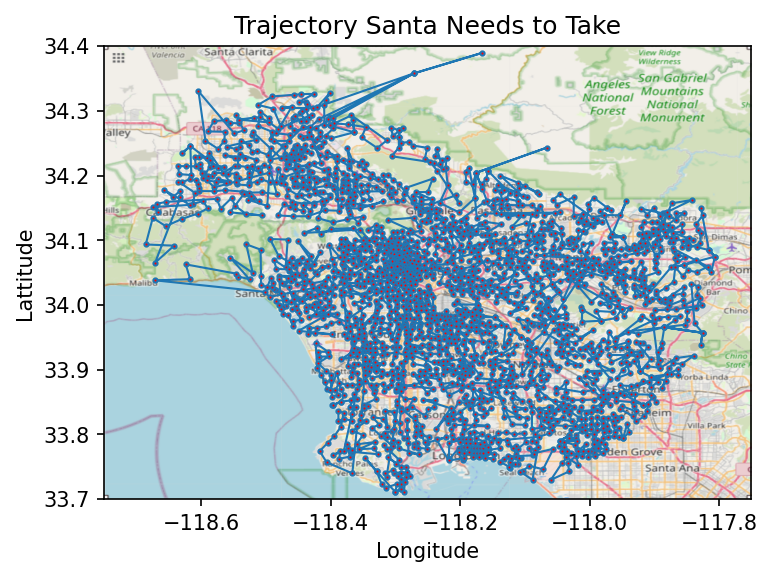

In [111]:
x = [gcc.vs[i]['centloc'][0] for i in path_approx]
y = [gcc.vs[i]['centloc'][1] for i in path_approx]
bbox = ((-118.75, -117.75, 33.7, 34.4))
la_map = plt.imread('la.png')
plt.figure(dpi=150)
plt.plot(x, y, marker='o', linewidth=1, markersize=2, markerfacecolor='red')
plt.title('Trajectory Santa Needs to Take')
plt.xlabel('Longitude')
plt.ylabel('Lattitude')
plt.xlim(bbox[0],bbox[1])
plt.ylim(bbox[2],bbox[3])
plt.imshow(la_map, zorder=0, extent=bbox, aspect='equal')
plt.savefig('images/' + 'Q13' + '.png', dpi=300, bbox_inches='tight')
plt.show()

### Question 14

In [93]:
def plot_graph(g, title=''):
  plt.figure(dpi=150)
  for e in g.es:
    v1 = g.vs[e.source]['centloc']
    v2 = g.vs[e.target]['centloc']
    data = np.vstack([v1, v2])
    x = data[:, 0]
    y = data[:, 1]
    plt.plot(x, y, c='r' if e['mark'] else 'b', linewidth=1)

  plt.title(title)
  plt.xlabel('Longitude')
  plt.ylabel('Lattitude')
  plt.imshow(la_map, zorder=0, extent=bbox, aspect='equal')
  plt.xlim(bbox[0],bbox[1])
  plt.ylim(bbox[2],bbox[3])
  # plt.savefig('images/' + title.replace(" ","-") + '.png', dpi=300, bbox_inches='tight')
  # plt.show()

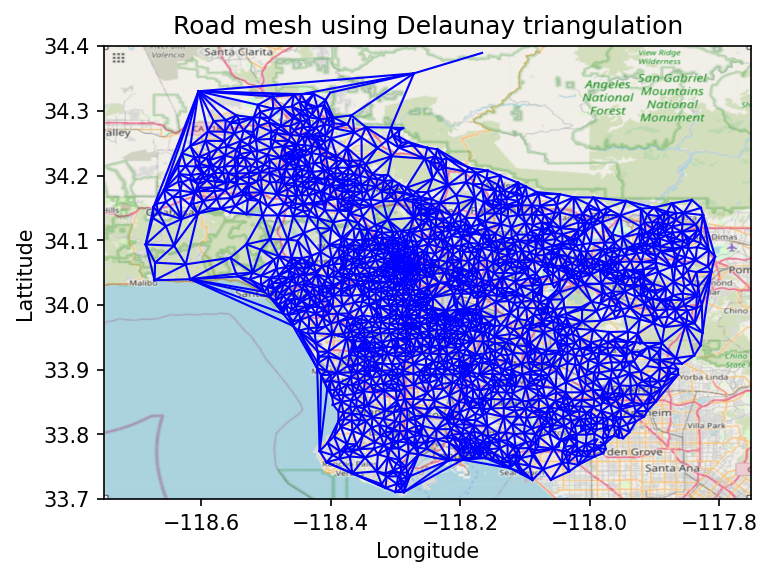

In [94]:
delaunay = Delaunay(gcc.vs['centloc'])
edges_d = []
for i in range(delaunay.simplices.shape[0]):
    for a, b in ((0, 1), (1, 2), (0, 2)):
        if gcc.are_connected(delaunay.simplices[i][a], delaunay.simplices[i][b]):
            edges_d.append((delaunay.simplices[i][a], delaunay.simplices[i][b]))
g_d = gcc.subgraph_edges(edges_d)
plot_graph(g_d, 'Road mesh using Delaunay triangulation')
plt.savefig('images/' + 'Q14' + '.png', dpi=300, bbox_inches='tight')
plt.show()

### Question 15

In [95]:
v = np.array(g_d.es['distance']) / np.array(g_d.es['time']) * 3600
dt = (0.003 / v) + (2 / 3600)
capacity = 4 / dt
g_d.es['capacity'] = capacity

### Question 16

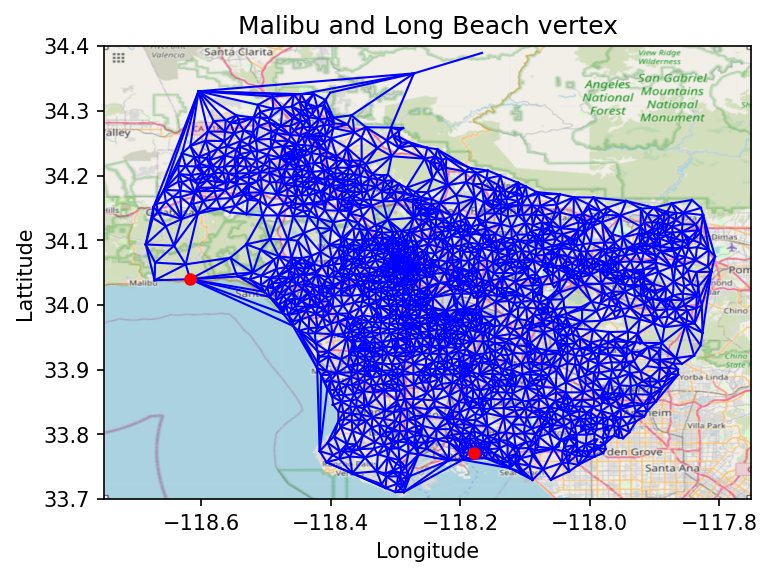

In [96]:
malibu = [-118.62, 34.026]
longbeach = [-118.18, 33.77]
v_loc = np.array(g_d.vs['centloc'])
malibu_dis = np.linalg.norm((v_loc - malibu), axis=1)
malibu_v = np.argmin(malibu_dis)
longbeach_dis = np.linalg.norm((v_loc - longbeach), axis=1)
longbeach_v = np.argmin(longbeach_dis)
plot_graph(g_d, 'Malibu and Long Beach vertex')
plt.plot(g_d.vs[malibu_v]['centloc'][0], g_d.vs[malibu_v]['centloc'][1], 'o', color='red', markersize=5)
plt.plot(g_d.vs[longbeach_v]['centloc'][0], g_d.vs[longbeach_v]['centloc'][1], 'o', color='red', markersize=5)
plt.savefig('images/' + 'Q16a' + '.png', dpi=300, bbox_inches='tight')
plt.show()

In [97]:
maxflow = g_d.maxflow_value(malibu_v, longbeach_v, capacity='capacity')
print(maxflow)
print(g_d.edge_connectivity(malibu_v, longbeach_v))
print(g_d.degree(malibu_v))
print(g_d.degree(longbeach_v))

30642.11323595776
6
9
6


In [98]:
def plot_local(g, v, title=''):
  plt.figure(dpi=150)
  for e in g.es:
    v1 = g.vs[e.source]['centloc']
    v2 = g.vs[e.target]['centloc']
    data = np.vstack([v1, v2])
    x = data[:, 0]
    y = data[:, 1]
    plt.plot(x, y, c='b', linewidth=1)

  plt.plot(g.vs[v]['centloc'][0], g.vs[v]['centloc'][1], 'o', color='red', markersize=5)
  plt.title(title)
  plt.xlabel('Longitude')
  plt.ylabel('Lattitude')
  plt.xlim(g.vs[v]['centloc'][0]-0.05,g.vs[v]['centloc'][0]+0.05)
  plt.ylim(g.vs[v]['centloc'][1]-0.05,g.vs[v]['centloc'][1]+0.05)

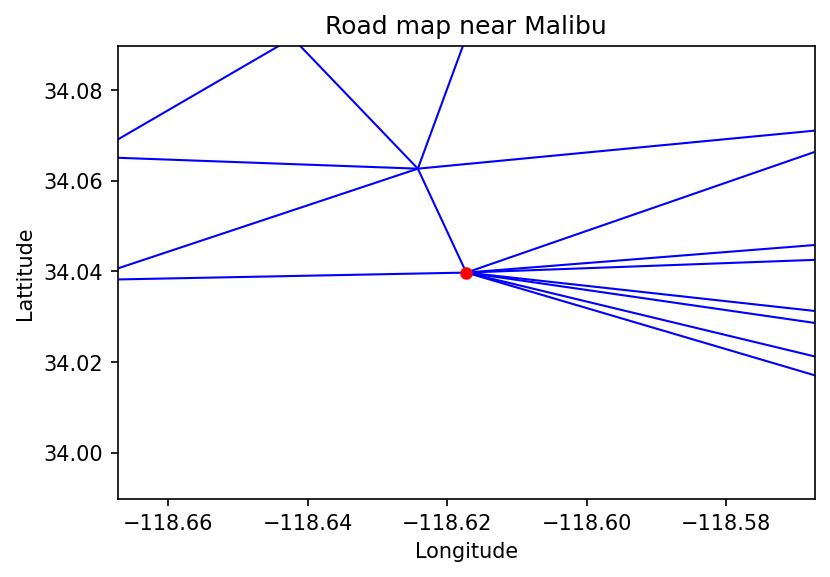

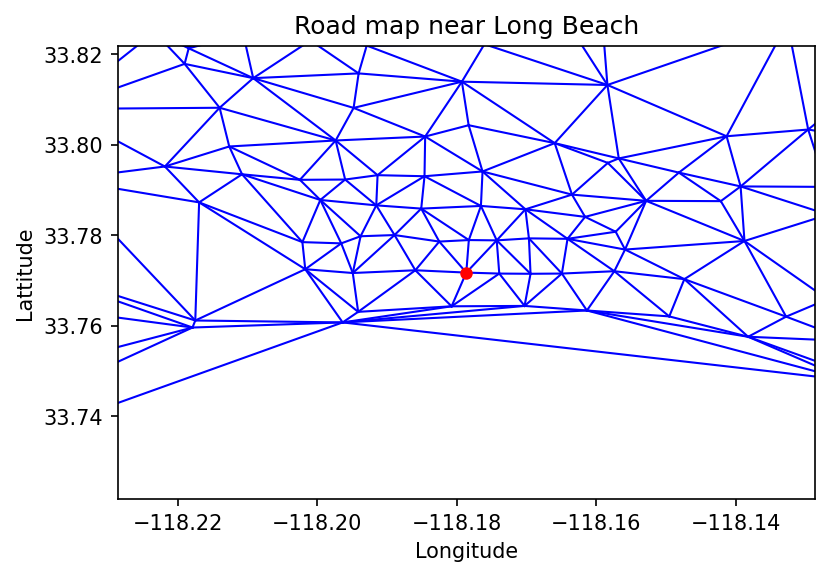

In [99]:
plot_local(g_d, malibu_v, 'Road map near Malibu')
plt.savefig('images/' + 'Q16b' + '.png', dpi=300, bbox_inches='tight')
plt.show()
plot_local(g_d, longbeach_v, 'Road map near Long Beach')
plt.savefig('images/' + 'Q16c' + '.png', dpi=300, bbox_inches='tight')
plt.show()

### Question 17

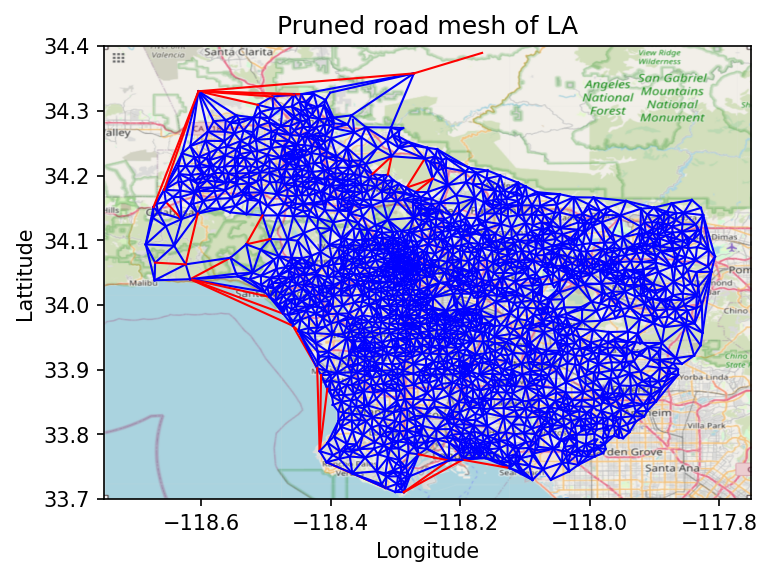

In [100]:
threshold_time = 800
edges_trim = g_d.es.select(time_le=threshold_time)
for e in g_d.es:
  if e not in edges_trim:
    e['mark'] = True
g_trim = g_d.subgraph_edges(edges_trim)
plot_graph(g_d, 'Pruned road mesh of LA')
plt.savefig('images/' + 'Q17' + '.png', dpi=300, bbox_inches='tight')
plt.show()

### Question 18

In [101]:
maxflow = g_trim.maxflow_value(malibu_v, longbeach_v, capacity='capacity')
print(maxflow)
print(g_trim.edge_connectivity(malibu_v, longbeach_v))
print(g_trim.degree(malibu_v))
print(g_trim.degree(longbeach_v))

30642.113235957757
5
5
6


### Question 19

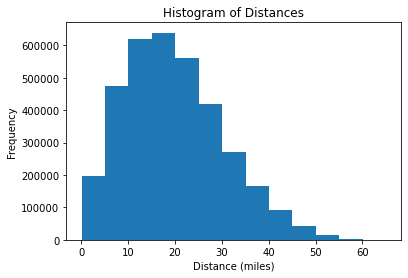

In [103]:
v_loc = g_trim.vs['centloc']
v_loc =  np.expand_dims(v_loc, axis=0)
v_loc_T = v_loc.transpose(1, 0, 2)
geo_dis = np.linalg.norm((v_loc - v_loc_T), axis=2) * 69
geo_triu = np.triu(geo_dis, 1)
geo_flat = geo_dis[geo_triu.nonzero()]
binwidth = 5
bins = np.arange(np.min(geo_flat), np.max(geo_flat) + binwidth, binwidth)
plt.hist(geo_flat, bins=bins)
plt.xlabel('Distance (miles)')
plt.ylabel('Frequency')
plt.title('Histogram of Distances')
plt.savefig('images/' + 'Q19a' + '.png', dpi=300, bbox_inches='tight')
plt.show()

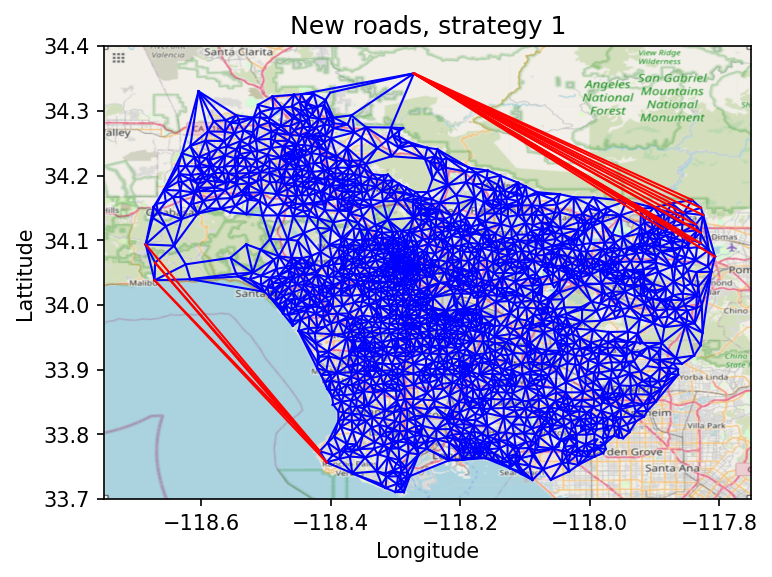

In [106]:
g_s1 = deepcopy(g_trim)
shortest_dis = g_s1.shortest_paths(weights='distance')
extra_dis = shortest_dis - geo_dis
extra_dis = np.triu(extra_dis, 1)
v_source, v_target = np.unravel_index(np.argsort(extra_dis, axis=None), extra_dis.shape)
edges_extra = list(zip(v_source[-20:], v_target[-20:]))
edges_dict = defaultdict(list)
edges_dict['distance'] = geo_dis[v_source[-20:], v_target[-20:]]
edges_dict['mark'] = [True] * 20
g_s1.add_edges(edges_extra, attributes=edges_dict)
plot_graph(g_s1, 'New roads, strategy 1')
plt.savefig('images/' + 'Q19b' + '.png', dpi=300, bbox_inches='tight')
plt.show()

### Question 20

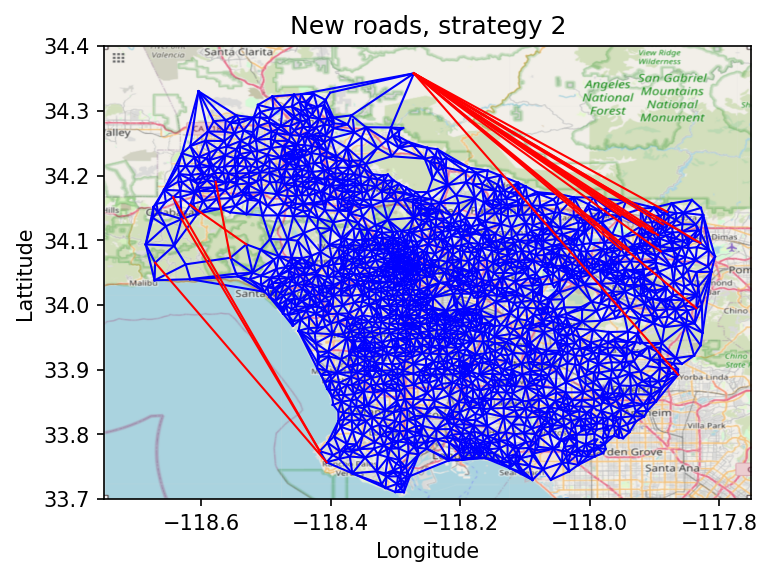

In [107]:
g_s2 = deepcopy(g_trim)
frequencies = np.random.randint(1, 1001, (len(g_s2.vs), len(g_s2.vs)))
extra_dis_w = np.multiply(extra_dis, frequencies)
v_source, v_target = np.unravel_index(np.argsort(extra_dis_w, axis=None), extra_dis_w.shape)
edges_extra = list(zip(v_source[-20:], v_target[-20:]))
edges_dict = defaultdict(list)
edges_dict['distance'] = geo_dis[v_source[-20:], v_target[-20:]]
edges_dict['mark'] = [True] * 20
g_s2.add_edges(edges_extra, attributes=edges_dict)
plot_graph(g_s2, 'New roads, strategy 2')
plt.savefig('images/' + 'Q20' + '.png', dpi=300, bbox_inches='tight')
plt.show()

### Question 21

100%|██████████| 20/20 [01:05<00:00,  3.26s/it]


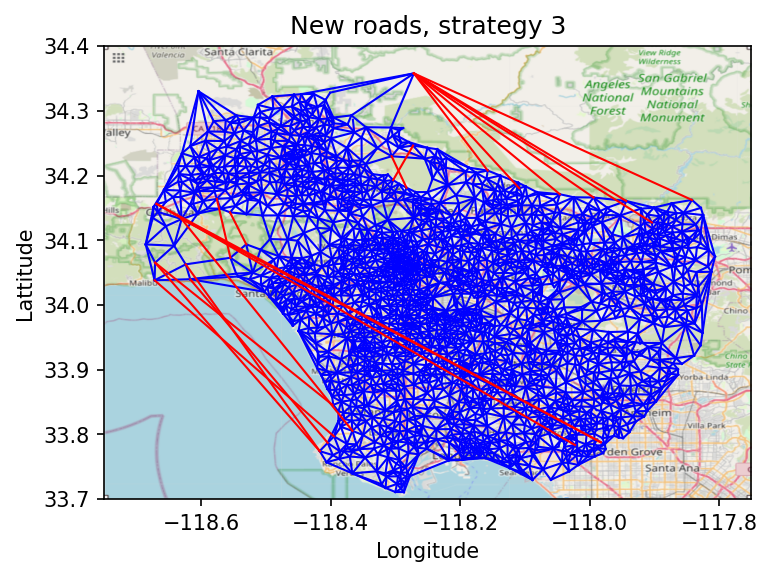

In [108]:
g_s3 = deepcopy(g_trim)
for i in tqdm(range(20)):
    shortest_dis = g_s3.shortest_paths(weights='distance')
    extra_dis = shortest_dis - geo_dis
    extra_dis = np.triu(extra_dis, 1)
    v_source, v_target = np.unravel_index(np.argsort(extra_dis, axis=None), extra_dis.shape)
    edges_extra = list(zip(v_source[-1:], v_target[-1:]))
    edges_dict = defaultdict(list)
    edges_dict['distance'] = geo_dis[v_source[-1:], v_target[-1:]]
    edges_dict['mark'] = [True] * 1
    g_s3.add_edges(edges_extra, attributes=edges_dict)
plot_graph(g_s3, 'New roads, strategy 3')
plt.savefig('images/' + 'Q21' + '.png', dpi=300, bbox_inches='tight')
plt.show()

### Question 22

C:\Users\23271\AppData\Local\Temp\ipykernel_23156\3213738132.py:4: RuntimeWarning: invalid value encountered in true_divide
  speed = shortest_dis / shortest_time


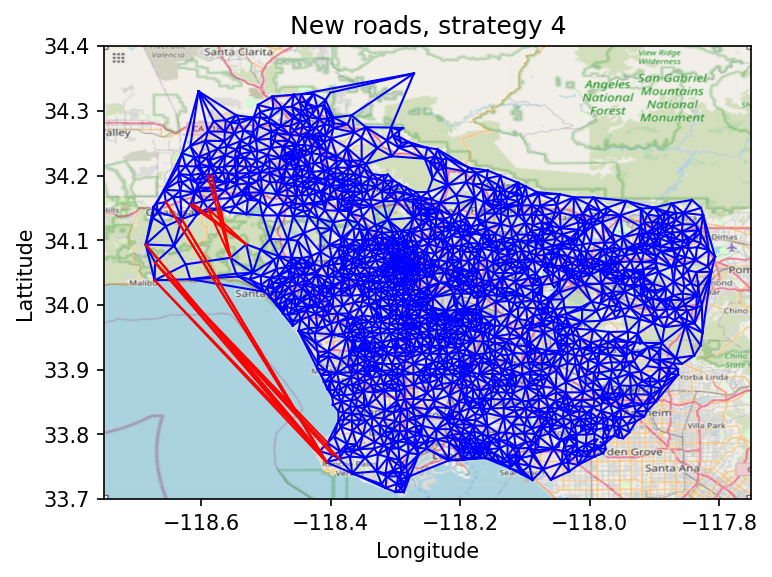

In [109]:
g_s4 = deepcopy(g_trim)
shortest_dis = np.array(g_s4.shortest_paths(weights='distance'))
shortest_time = np.array(g_s4.shortest_paths(weights='time'))
speed = shortest_dis / shortest_time
extra_time = shortest_time - geo_dis / speed
extra_time = np.triu(extra_time, 1)
v_source, v_target = np.unravel_index(np.argsort(extra_time, axis=None), extra_time.shape)
edges_extra = list(zip(v_source[-20:], v_target[-20:]))
edges_dict = defaultdict(list)
edges_dict['distance'] = geo_dis[v_source[-20:], v_target[-20:]]
edges_dict['mark'] = [True] * 20
g_s4.add_edges(edges_extra, attributes=edges_dict)
plot_graph(g_s4, 'New roads, strategy 4')
plt.savefig('images/' + 'Q22' + '.png', dpi=300, bbox_inches='tight')
plt.show()

### Question 23

  0%|          | 0/20 [00:00<?, ?it/s]C:\Users\23271\AppData\Local\Temp\ipykernel_23156\873331965.py:5: RuntimeWarning: invalid value encountered in true_divide
  speed = shortest_dis / shortest_time
100%|██████████| 20/20 [01:46<00:00,  5.31s/it]


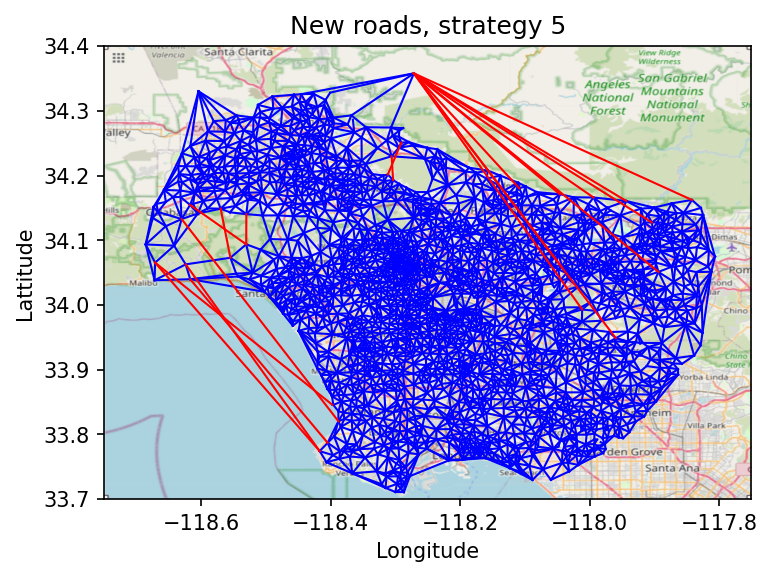

In [110]:
g_s5 = deepcopy(g_trim)
for i in tqdm(range(20)):
    shortest_dis = np.array(g_s5.shortest_paths(weights='distance'))
    shortest_time = np.array(g_s5.shortest_paths(weights='time'))
    speed = shortest_dis / shortest_time
    extra_time = shortest_time - geo_dis / speed
    extra_time = np.triu(extra_time, 1)
    v_source, v_target = np.unravel_index(np.argsort(extra_time, axis=None), extra_time.shape)
    edges_extra = list(zip(v_source[-1:], v_target[-1:]))
    edges_dict = defaultdict(list)
    edges_dict['distance'] = geo_dis[v_source[-1:], v_target[-1:]]
    edges_dict['time'] = geo_dis[v_source[-1:], v_target[-1:]] / speed[v_source[-1:], v_target[-1:]]
    edges_dict['mark'] = [True] * 1
    g_s5.add_edges(edges_extra, attributes=edges_dict)
plot_graph(g_s5, 'New roads, strategy 5')
plt.savefig('images/' + 'Q23' + '.png', dpi=300, bbox_inches='tight')
plt.show()